legi: 11-912-2243

# SLT-CE-3: Histogram Clustering

In this coding exercise you will apply histogram clustering (HC) in order to segment an image. You will implement two different methods (maximum a posterior (MAP) and deterministic annealing (DA)) in order to predict the clusters membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981/ 

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

import copy
from skimage.util.shape import view_as_windows

## Texture and corresponding label map
(This texture is used to fit your model.)

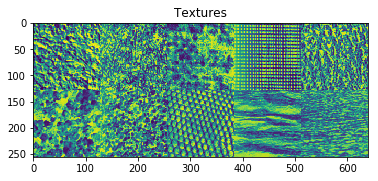

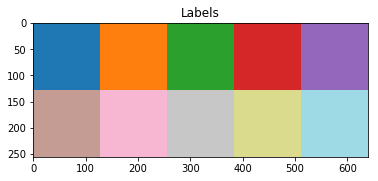

In [3]:
texture = imread("texture.png")

patch_grid_shape = (2,5)
patch_shape = (128,128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)] = np.ravel_multi_index((i,j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

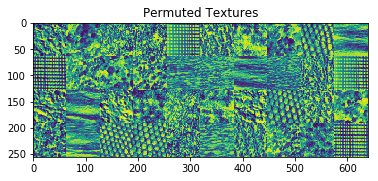

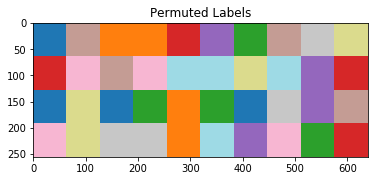

In [4]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i//2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape)
    
    perm_texture[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                 jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    texture[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
            j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
    perm_label_map[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                   jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    label_map[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
              j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both, Maximum a Posteriori estimation and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference [1] looks for the case of DA (using the notation of reference [1]). Hint: try to reformulate $\hat P(y|c)$ in terms of $\hat P(c|x)$ and use the maximum entropy principle to find an expression for $\hat P(c|x)$.
</p>

In [ ]:
Cluster in distributional data can be accomplished based on distributional similarity, i.e. objects with similar feature distributions are grouped together. Here we try to group image patches (objects) with similar distribution of gray values (features) by optimizing the cost function: 
$$ \mathcal{R}^{hc}=(c,q)= \frac{l}{n} \sum_{i\le n}D_{KL}(\hat{P}(\cdot |i) || P(\cdot |c(i)))$$

In the MAP parameter estimation we have to maximize the log-posterior distribution:
$$L(x,\theta, n) = \sum_{x in X} n(x) \left [ \sum_{y \in Y} \hat{P}(y|x) \log P(y|c(x)) + log P(x) \right ] + \log P(c)$$

- $\hat{P}(x)= \frac{n(x)}{\sum_{x':\hat{c}(x')=c} n(x')}$
- $\hat{P}(y|c)= \sum_{x:\hat{c}(x)=c}\frac{n(x)}{\sum_{x':\hat{c}(x')=c} n(x')} \hat{P}(y|x)$
- $\hat{P}(y|x) = \frac{n(x,y)}{n(x)}$
- $\hat{c}(x) = \text{argmin}_{a} \{ -\sum_{y \in Y} \hat{P}(y|x) \log \hat{P}(y|a) - \log P(\hat{c}^x_a) \}$

In the case of DA, equation (5) becomes $\hat{P}(y|c)= \frac{1}{W} \sum_{x \in X} n(x,y) \frac{\hat{P}(c|x,\theta)}{\sum_{x'\in X}\hat{P}(c|x',\theta)}$, $P(c|x,\theta)=\frac{\exp(-h(x,a;\theta)/T)}{\sum_{b=1}^K \exp(-h(x,b;\theta)/T)}$
                                                                                                                    

In [95]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins =n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation        # Add more parameters, if necessary.
    
    def _histrogram_distance_(self,X):
        window = view_as_windows(np.pad(X, int((self.window_size-1)/2), mode='symmetric'), (self.window_size,self.window_size))
        #i is the index patch
        hist = np.histogram(i, bins= self.n_bins, range=(0,1), weights=None, density=None);

        
        win= window.reshape(-1, self.window_size, self.window_size)

    
        histograms= np.array([[0] for i in win])
        return histograms / (self.window_size**2)
    
    def _cluster_assigment(self, histogram_d):
        assignment_list = [np.argmax(np.sum(hist_d * np.log(self.centroids+0.00001), axis=1)) for hist_d in histogram_d]
        
        return np.array(assignment_list)
    
    def fit(self, X):
        """ Compute HC for input image X
        Compute centroids P(y|c)
        
        """
        #Initlize centroids p(y|c) abd cluster assigments c(x)
        self.centroids = np.random.uniform(low=0, high=1, size=(self.n_clusters, self.n_bins))
        self.cluster_assign = np.random.randint(self.n_clusters, size=X.size)
        
        #Compute the histogtram distributions P(y|x) for every pixel
        self.histogram_dist = self._histrogram_distance_(X)
        
        if self.estimation == "MAP":
            prev_centroids = np.ones((self.n_clusters, self.n_bins))
            #np.linalg.norm returns matrix norm
            while (np.linalg.norm(self.centroids-prev_centroids) > 0.1): # gets distance
                print("One more time")
                prev_centroids = copy.deepcopy(self.centroids)
                
                for c in range(self.n_clusters):
                    self.centroids[c] = np.mean(self.histogram_dist[self.cluster_assign==c], axis=0)
                    self.cluster_assign = self._cluster_assigment(self.histogram_dist)
        
        elif self.estimation == "DA":
            raise NotImplementedError
        return self
    
    def predict(self, X):
        """Predict cluster assigments c(x) for each pixel in image X.
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            C (np.ndarray): Assigment map(height, width)
            
        """
        check_is_fitted(self,["centroids"])
        histogram_d = self._histrogram_distance_((x)
        assigments = self._cluster_assigment(histogram_d)
        
        return assigments.reshape(X.shape)
        

    
    

/home/paulina/anaconda3/envs/slt-ce/lib/python3.5/site-packages/skimage/util/shape.py:255: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr_in[slices].strides


One more time


/home/paulina/anaconda3/envs/slt-ce/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paulina/anaconda3/envs/slt-ce/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


CPU times: user 24.7 s, sys: 185 ms, total: 24.9 s
Wall time: 25 s


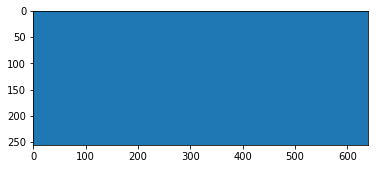

In [96]:
%%time
HC = HistogramClustering(n_clusters=10, n_bins=64, window_size=25, estimation="MAP")
HC._histrogram_distance_(texture)
HC.fit(texture)
check_is_fitted(HC, ["centroids"])
plt.imshow(HC.cluster_assign.reshape(256,640), cmap="tab20")

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

/home/paulina/anaconda3/envs/slt-ce/lib/python3.5/site-packages/skimage/util/shape.py:255: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr_in[slices].strides


One more time
One more time
One more time
CPU times: user 19.5 s, sys: 225 ms, total: 19.7 s
Wall time: 19.9 s


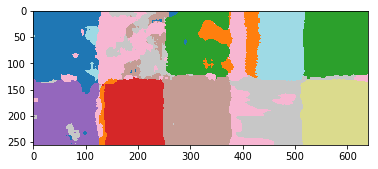

In [8]:
%%time
HC = HistogramClustering(n_clusters=10, n_bins=64, window_size=25, estimation="MAP")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])
plt.imshow(HC.cluster_assign.reshape(256,640), cmap="tab20")

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [98]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

AttributeError: 'HistogramClustering' object has no attribute '_histogram_distance_'

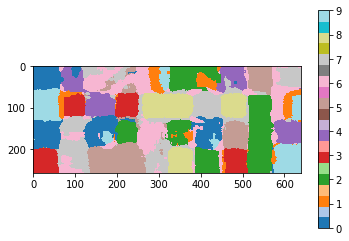

In [11]:
# Plot of predicted label map
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.colorbar()

<p style="background-color:#adebad;">
    Plot a confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, so that they are in correpondence with the true labels (see Hungarian algortihm to find the best match).
</p>

In [18]:
def permute_to_true_labels(predicted_perm_label_map):
    # Assignment Problem: Properly assign the predicted to the true labels
    # Note: This is a maximum matching problem in the bipartite graph of labels and ground truth labels

    ## Determine histogram of label assignments with regard to ground truth label
    labels=np.zeros((np.prod(patch_grid_shape), np.prod(patch_grid_shape)))

    for patch in range(np.prod(perm_patch_grid_shape)):
        i, j = np.unravel_index(patch, perm_patch_grid_shape)
        unique, counts = np.unique(
            predicted_perm_label_map[perm_patch_shape[0]*i:perm_patch_shape[0]*(i+1),
                                     perm_patch_shape[1]*j:perm_patch_shape[1]*(j+1)], return_counts=True)
        histogram = np.zeros(np.prod(patch_grid_shape))
        histogram[unique] = counts
        labels[int(perm_label_map[perm_patch_shape[0]*i, perm_patch_shape[1]*j])] += histogram

    #sorted_labels = np.array([np.argsort(label)[::-1] for label in labels])

    ## Use Hungarian Method to solve assignment problem (assign each label the best ground truth label)
    from scipy.optimize import linear_sum_assignment
    label_assignments = linear_sum_assignment(-labels.T)[1]

    ## Construct the new predcited_perm_label_map from the new assignments
    predicted_perm_label_map_sorted = -1 * np.ones_like(predicted_perm_label_map)
    for label in range(np.prod(patch_grid_shape)):
        predicted_perm_label_map_sorted[predicted_perm_label_map==label] = label_assignments[label]
    
    return predicted_perm_label_map_sorted  


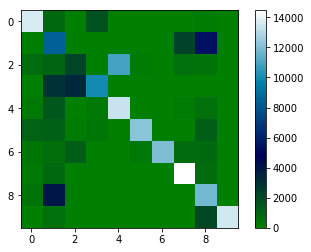

In [19]:
# Confusion matrix
predicted_perm_label_map_sorted = permute_to_true_labels(predicted_perm_label_map)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(perm_label_map.reshape(-1), predicted_perm_label_map_sorted.reshape(-1))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()

In [20]:

np.sum(predicted_perm_label_map_sorted==perm_label_map) / np.prod(perm_label_map.shape)

0.683819580078125

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [21]:
# Compute the grid search
accuracy_mat = np.zeros((3,3))
prediction = []
for i, n_bins in enumerate(np.array([16, 32, 64 ])):
    for j, window_size in enumerate(np.array([7, 9, 11])):
        grid_HC = HistogramClustering(n_clusters=10, n_bins=n_bins, window_size=window_size, estimation="MAP")
        grid_HC.fit(texture)
        prediction.append(grid_HC.predict(perm_texture))
        prediction_sorted = permute_to_true_labels(prediction[-1])
        accuracy_mat[i,j] = np.sum(prediction_sorted==perm_label_map) / np.prod(perm_label_map.shape)     

/home/paulina/anaconda3/envs/slt-ce/lib/python3.5/site-packages/skimage/util/shape.py:255: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr_in[slices].strides


One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time
One more time


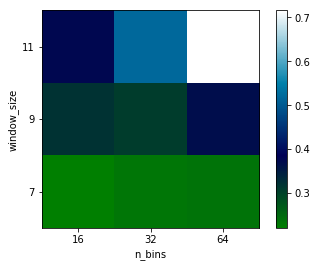

In [22]:


# 3x3 Matrix with accuracy scores of the different parameter combination
fig, ax = plt.subplots()

plt.imshow(accuracy_mat, interpolation='nearest', cmap=plt.cm.ocean)

plt.xlabel('n_bins')
plt.ylabel('window_size')
plt.gca().invert_yaxis()
plt.colorbar()

ax.set_xticks(np.arange(0,3))
ax.set_yticks(np.arange(0,3))

ax.set_xticklabels([16, 32, 64])
ax.set_yticklabels([7, 9, 11])

plt.show()

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them properly.
    </p>

/home/paulina/anaconda3/envs/slt-ce/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


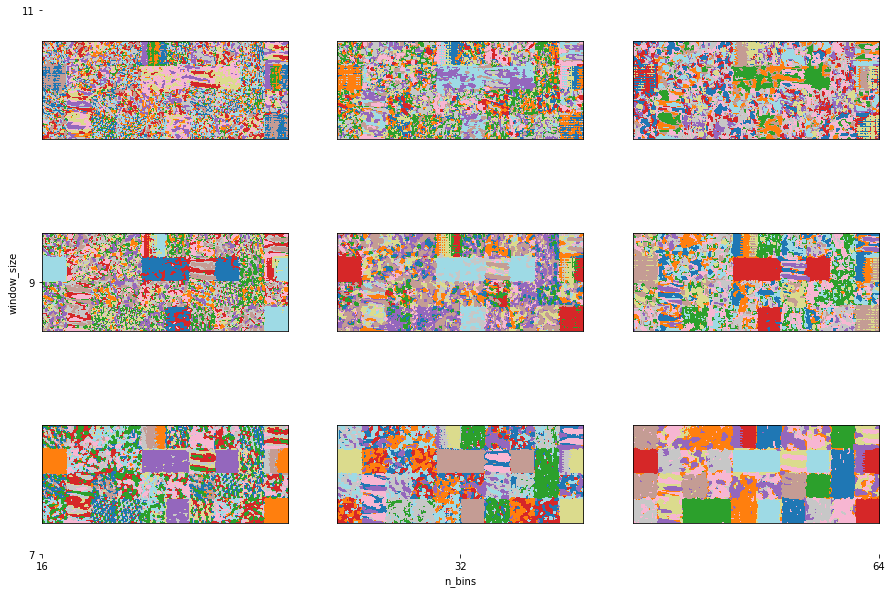

In [24]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i in range(9):
    plt.subplot(330+i+1)
    plt.tick_params(labelcolor='none', top='False', bottom='False', left='False', right='False')
    plt.imshow(prediction[i], cmap="tab20")

big_ax = fig.add_subplot(111, frameon=False)
plt.xlabel('n_bins')
plt.ylabel('window_size')

big_ax.set_xticks(np.arange(0,3))
big_ax.set_yticks(np.arange(0,3))

big_ax.set_xticklabels([16, 32, 64])
big_ax.set_yticklabels([7, 9, 11])

plt.show()

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

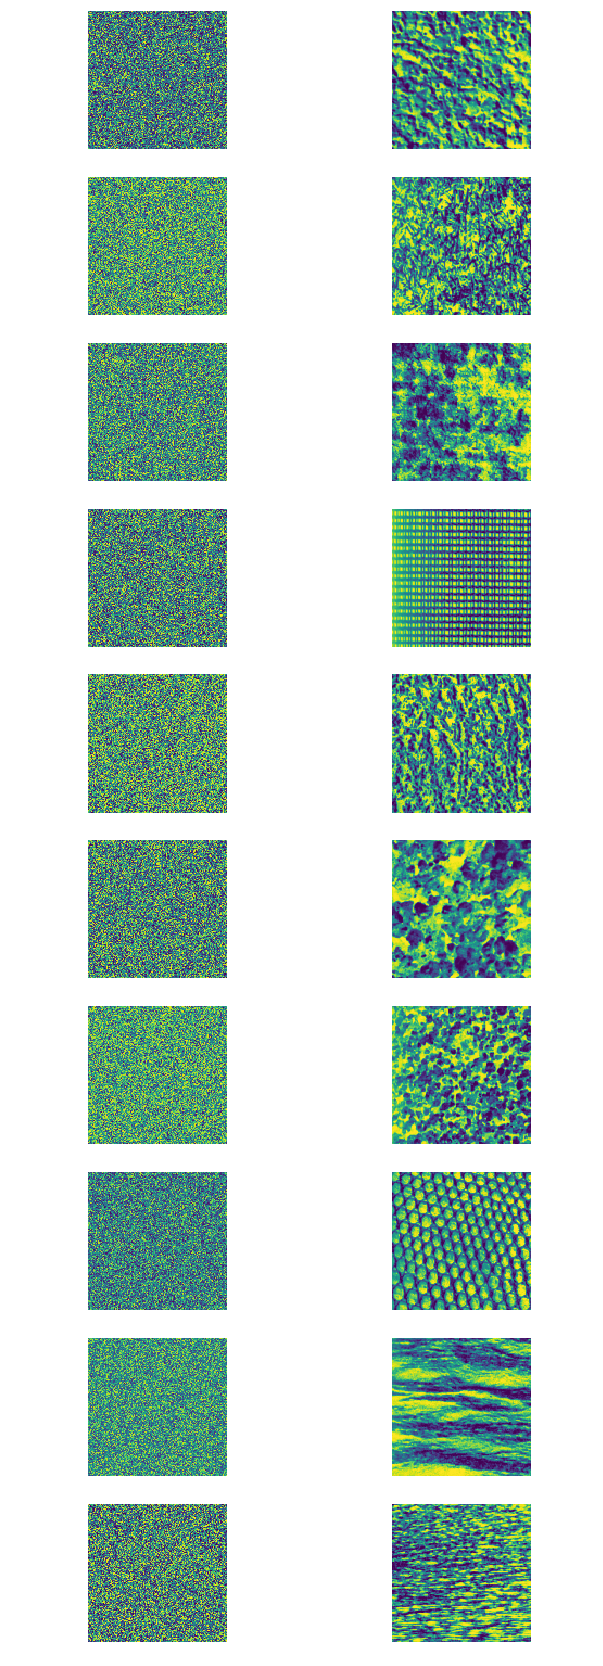

In [25]:
# Generated texture plots
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,30))
np.vectorize(lambda ax:ax.axis('off'))(ax)

for i in range(10):
    C = np.ones(patch_shape) * i
    X_current = HC.generate(C)
    
    # Plot generated texture
    fig.add_subplot(10,2,2*i+1)
    plt.imshow(X_current)
    plt.axis('off')
    
    # Plot ground truth texture
    patch_texture = texture[label_map==i].reshape(patch_shape)
    fig.add_subplot(10,2,2*i+2)
    plt.imshow(patch_texture)
    plt.axis('off')
# Generated texture plot

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [ ]:
# Predicted label map for k-means
# Predicted label map for HC

<ul style="background-color:#adebad;">
    <li>
        Moreover, plot and compare the confusion matrices for both, K-means, and HC.
    </li>
</ul>

In [ ]:
# Confusion matrices

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

In [ ]:
# Histograms

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [ ]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. What can you observe?
        </li>
    </ul>

In [ ]:
# Clustering at different temperatures

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.